In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes),'uint8')
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [4]:
labels = LabelEncoder().fit(df_train['species'])
y_train = labels.transform(df_train['species'])
#y_train = onehot(y_train,len(np.unique(y_train)))
x_train = np.array(df_train.drop(['id','species'],axis=1))
x_test = np.array(df_test)

In [5]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train,test_size=0.20,random_state=0)

In [6]:
n_classes = len(np.unique(y_train))
n_features = x_train.shape[1]

n_nodes_hl1 = 200
n_nodes_hl2 = 200

batch_size = 100 # batches of features feed to network

x = tf.placeholder('float', [None, n_features])
y = tf.placeholder('float')

In [7]:
def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([n_features, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes])),}

 	# (input_data * weights) + biases

    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    output = tf.matmul(l2,output_layer['weights']) + output_layer['biases']
    
    return output

In [20]:
def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    #cost = tf.reduce_mean( -tf.reduce_mean(tf.log(prediction)*y, reduction_indices=[1]) )
    # optimizer has a default parameter- learning rate = 0.01
    ##optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
    optimizer = tf.train.AdamOptimizer(0.1).minimize(cost)
    
    hm_epochs = 500 #cycles feedforward+backward
    train = []
    valid = []
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(len(train_x)//batch_size):
                idx = range(i*batch_size, (i+1)*batch_size)
                epoch_x = train_x[idx]
                epoch_y = train_y[idx]
                _, c = sess.run([optimizer, cost], feed_dict={x:epoch_x, y:onehot(epoch_y,n_classes)})
                epoch_loss += c
            
            train_accu = accuracy.eval({x:train_x, y:onehot(train_y,n_classes)})
            valid_accu = accuracy.eval({x:valid_x, y:onehot(valid_y,n_classes)})
            train += [train_accu]
            valid += [valid_accu]    
            print ('Epoch', epoch+1,'loss:',epoch_loss,'train_accu:',train_accu,'valid_accu:',valid_accu)
            
        plt.figure()
        plt.plot(np.arange(len(train)),train,'r',valid,'b')
        plt.legend(['train','valid'])
        #test_acc = accuracy.eval({x:x_test, y:y_test})
        #print('test_acc:',test_acc)

Epoch 1 loss: 1486.87451172 train_accu: 0.0164141 valid_accu: 0.0151515
Epoch 2 loss: 325.784936905 train_accu: 0.0984849 valid_accu: 0.0909091
Epoch 3 loss: 49.2350921631 train_accu: 0.135101 valid_accu: 0.121212
Epoch 4 loss: 27.4041395187 train_accu: 0.267677 valid_accu: 0.156566
Epoch 5 loss: 19.7192900181 train_accu: 0.416667 valid_accu: 0.262626
Epoch 6 loss: 13.7940909863 train_accu: 0.569444 valid_accu: 0.393939
Epoch 7 loss: 9.0396464467 train_accu: 0.727273 valid_accu: 0.510101
Epoch 8 loss: 5.59688782692 train_accu: 0.834596 valid_accu: 0.580808
Epoch 9 loss: 3.36358323693 train_accu: 0.875 valid_accu: 0.621212
Epoch 10 loss: 2.0758883357 train_accu: 0.924242 valid_accu: 0.651515
Epoch 11 loss: 1.32477554679 train_accu: 0.945707 valid_accu: 0.656566
Epoch 12 loss: 0.766810402274 train_accu: 0.954545 valid_accu: 0.671717
Epoch 13 loss: 0.529178153723 train_accu: 0.965909 valid_accu: 0.676768
Epoch 14 loss: 0.304568633437 train_accu: 0.968434 valid_accu: 0.69697
Epoch 15 loss:

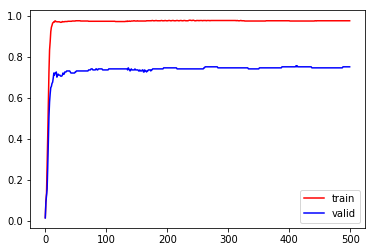

In [21]:
train_neural_network(x)

In [8]:
train_x.shape

(841, 192)

In [30]:
train_y.shape

(841, 99)

In [13]:
t = np.matrix(train_y)

In [15]:
onehot(t,99).shape

(841, 99)

In [17]:
len(np.unique(y_train)),df_train.shape[1]

(99, 194)

array([0, 1], dtype=uint8)